In [22]:
!pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm

In [24]:
# Load data
data_csv = 'data/pickups_aggregated.csv'
data = pd.read_csv(data_csv)

# Display basic info
print("Data Head:")
display(data.head())

print("\nData Info:")
data.info()

print("\nSummary Statistics:")
display(data.describe())

Data Head:


,LocationID,time_bin,pickups,day_of_week,hour,month,day,year,weekend
0,1,2016-01-01 02:00:00,1,4,2,1,1,2016,False
1,1,2016-01-01 04:00:00,1,4,4,1,1,2016,False
2,1,2016-01-01 05:00:00,1,4,5,1,1,2016,False
3,1,2016-01-01 07:00:00,1,4,7,1,1,2016,False
4,1,2016-01-01 10:00:00,1,4,10,1,1,2016,False



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112942 entries, 0 to 1112941
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   LocationID   1112942 non-null  int64 
 1   time_bin     1112942 non-null  object
 2   pickups      1112942 non-null  int64 
 3   day_of_week  1112942 non-null  int64 
 4   hour         1112942 non-null  int64 
 5   month        1112942 non-null  int64 
 6   day          1112942 non-null  int64 
 7   year         1112942 non-null  int64 
 8   weekend      1112942 non-null  bool  
dtypes: bool(1), int64(7), object(1)
memory usage: 69.0+ MB

Summary Statistics:


,LocationID,pickups,day_of_week,hour,month,day,year
count,1.112942e+06,1.112942e+06,1.112942e+06,1.112942e+06,1.112942e+06,1.112942e+06,1112942.0
mean,1.404151e+02,1.178245e+02,3.069867e+00,1.155195e+01,6.476477e+00,1.574344e+01,2016.0
std,7.699671e+01,2.000225e+02,2.006259e+00,6.995260e+00,3.435898e+00,8.814855e+00,0.0
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2016.0
25%,7.500000e+01,2.000000e+00,1.000000e+00,6.000000e+00,4.000000e+00,8.000000e+00,2016.0
50%,1.420000e+02,1.700000e+01,3.000000e+00,1.200000e+01,6.000000e+00,1.600000e+01,2016.0
75%,2.150000e+02,1.500000e+02,5.000000e+00,1.800000e+01,9.000000e+00,2.300000e+01,2016.0
max,2.650000e+02,3.957000e+03,6.000000e+00,2.300000e+01,1.200000e+01,3.100000e+01,2016.0


Missing Values:
Series([], dtype: int64)


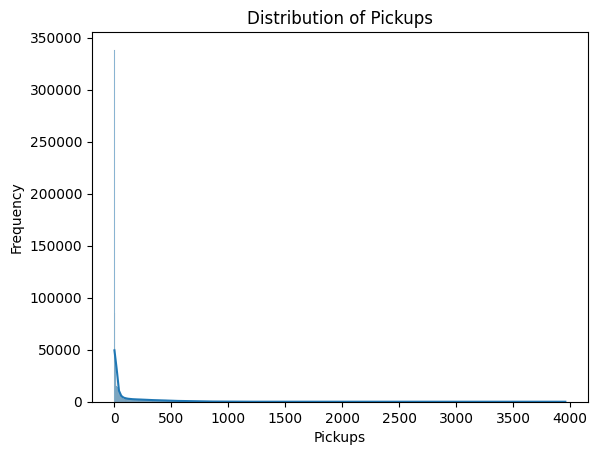

In [25]:
# Check missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0])

# Plot distribution of pickups
sns.histplot(data['pickups'], kde=True)
plt.title("Distribution of Pickups")
plt.xlabel("Pickups")
plt.ylabel("Frequency")
plt.show()


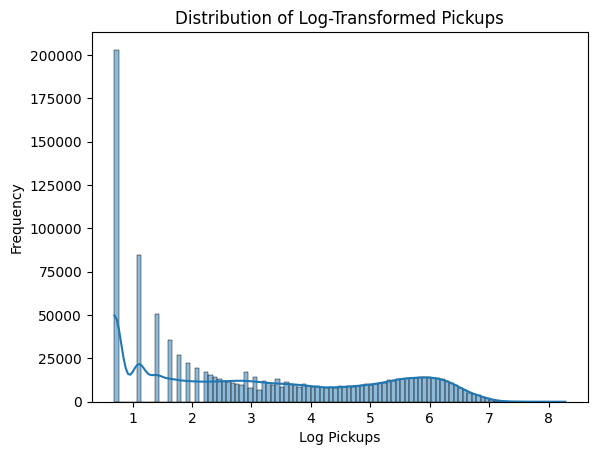

In [26]:
data['pickup_log'] = np.log1p(data['pickups'])

sns.histplot(data['pickup_log'], kde=True)
plt.title("Distribution of Log-Transformed Pickups")
plt.xlabel("Log Pickups")
plt.ylabel("Frequency")
plt.show()


In [27]:
# Feature Preparation and Label Encoding
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the data
data = pd.read_csv('data/pickups_aggregated.csv')

# Add log-transformed target variable
data['pickup_log'] = np.log1p(data['pickups'])

# Specify feature columns
features = ['LocationID', 'year', 'month', 'day', 'hour', 'day_of_week', 'weekend']
X = data[features].copy()
y = data['pickup_log']

# Define all possible LocationIDs for label encoding
all_location_ids = list(range(1, 266))  

print("Applying label encoding to 'LocationID'...")
le = LabelEncoder()
le.fit(all_location_ids)  
X['LocationID'] = le.transform(X['LocationID'])

# Save the label encoder for reuse
os.makedirs('models', exist_ok=True)
joblib.dump(le, 'models/locationid_label_encoder.pkl')

print("Features prepared and label encoding applied.")


Applying label encoding to 'LocationID'...
Features prepared and label encoding applied.


In [28]:
feature_names = X.columns

print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting data into training and test sets...


In [29]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest R²: {r2_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.4f}")


Random Forest R²: 0.9760
Random Forest RMSE: 0.3076


In [30]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print(f"Decision Tree R²: {r2_dt:.4f}")
print(f"Decision Tree RMSE: {rmse_dt:.4f}")


Decision Tree R²: 0.9571
Decision Tree RMSE: 0.4110


In [31]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost R²: {r2_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")


XGBoost R²: 0.8436
XGBoost RMSE: 0.7847


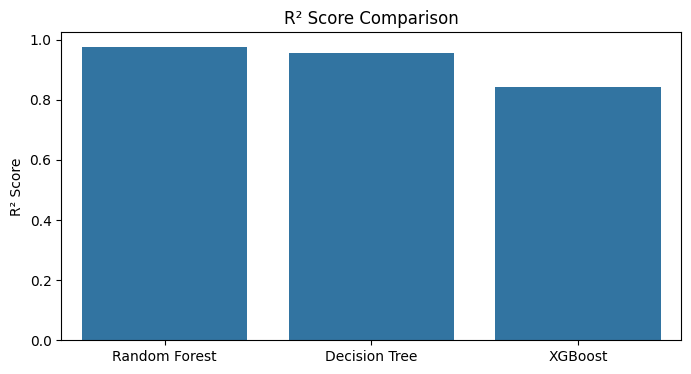

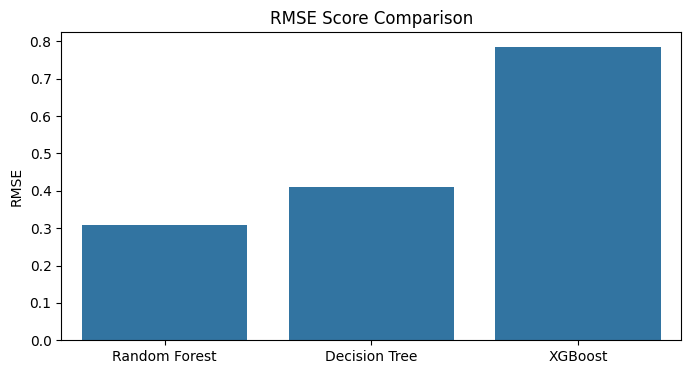

In [32]:
models = ['Random Forest', 'Decision Tree', 'XGBoost']
r2_scores = [r2_rf, r2_dt, r2_xgb]
rmse_scores = [rmse_rf, rmse_dt, rmse_xgb]

plt.figure(figsize=(8, 4))
sns.barplot(x=models, y=r2_scores)
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=models, y=rmse_scores)
plt.title("RMSE Score Comparison")
plt.ylabel("RMSE")
plt.show()


In [ ]:
# model_output_path = 'models/random_forest.pkl'
# os.makedirs('models', exist_ok=True)
# joblib.dump({'model': rf_model, 'feature_names': feature_names}, model_output_path)

In [33]:
rf_model = RandomForestRegressor(n_estimators=50, 
                                  max_depth=15, 
                                  min_samples_split=5, 
                                  min_samples_leaf=2, 
                                  random_state=42, 
                                  n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest R²: {r2_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.4f}")

# joblib.dump(rf_model, 'rf_model.pkl', compress=3)


Random Forest R²: 0.9112
Random Forest RMSE: 0.5912


In [34]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=15, random_state=42)
lgbm_model.fit(X_train, y_train)

y_pred_lgbm = lgbm_model.predict(X_test)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print(f"LightGBM R²: {r2_lgbm:.4f}")
print(f"LightGBM RMSE: {rmse_lgbm:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 890353, number of used features: 6
[LightGBM] [Info] Start training from score 3.137769
LightGBM R²: 0.9093
LightGBM RMSE: 0.5977


In [ ]:
# Using Decision tree instead of Random forest because the latter is too heavy for real time applications(6GB vs 100MB) 
model_output_path = 'models/decision_tree.pkl'
os.makedirs('models', exist_ok=True)
joblib.dump({'model': dt_model, 'feature_names': feature_names}, model_output_path)

['models/decision_tree.pkl']